# BCI Testbed for FATES

The purpose of this testbed code is to compare FATES output to observations at BCI, and also to understand some of the internal paramteric control over FATES predictions.  The overall order of things is to first load an ensemble of FATES model inputs, then look at several metrics of model predictions as projected onto the trait covariance matrices that were used to generate the model ensemble, and well as looking at several model predictions as compared to observed ecosystem states and fluxes at the BCI site.

#### First we will load all the libraries that we need

In [1]:
import netCDF4 as nc4
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
import map_funcs
from IPython.display import Image


# set the plot style
plt.style.use('seaborn-ticks')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, "lines.markersize": 6.0, 'lines.markeredgewidth': 1.0})
#sns.set_context("poster")

print(sns.__version__)

1.6.1
0.9.0


# First steps: load the data and plot some basic properties


Load all the FATES history output that was generated by the model ensemble, as well as the traits matrix input to the model.


In [2]:
### uncomment this for bare-ground runs
filename_history = '/Users/cdkoven/datasets/fates_output/bci_testbed/fates_clm5_fullmodel_bci_parameter_ensemble_2pfts_190416_multiinst_576inst_v3_cmpexcl3_b9c92b7_57b333d.h0.ensemble.sofar.nc'

## now load the size-structured data.  it is on a second history tape with an annual write frequency
filename_history2 = '/Users/cdkoven/datasets/fates_output/bci_testbed/fates_clm5_fullmodel_bci_parameter_ensemble_2pfts_190416_multiinst_576inst_v3_cmpexcl3_b9c92b7_57b333d.h1.ensemble.sofar.nc'

# ### uncomment this for inventory runs
# filename_history = '/Users/cdkoven/datasets/fates_output/bci_testbed/fates_clm5_fullmodel_bci_parameter_ensemble_1pft_v004inv_b1bf522_819609f.h0.ensemble.sofar.nc'

filename_params = '/Users/cdkoven/datasets/fates_output/bci_testbed/fates_params_default_106ac7a_mod2PFTs_exp2_cmpexcl3.ensemble.c190416.nc'

histfile = nc4.Dataset(filename_history)
paramfile = nc4.Dataset(filename_params)
histfile2 = nc4.Dataset(filename_history2)

traits_matrix = np.loadtxt('traits_matrix_used_in_param_files_190416.txt')


#### Next lets look at which ensemble members predict a surviving forest.  Calculate an index of survival and project that back on to the trait covariance matrix.

In [3]:
biomass_var = histfile.variables['ED_biomass']
nens = biomass_var.shape[0]
nts = biomass_var.shape[1]
nyears = nts/12
print(nens)

startyear = nyears-50
endyear = nyears-1


survival_threshold = 100.
survived = biomass_var[:,nts-1,0] > survival_threshold
print(' fraction of ensemble members with surviving forests = '+str(survived.sum()/float(nens)))


column_names = ['Vcmax25', 'wood_dens', 'LMA', 'N/area','leaf_life','b_mort','crown_dbh_coef','crown_dbh_exp','bleaf_dbh','fineroot_leaf','npp_repro','cstarv_mort']
ncols = len(column_names)
print(ncols)
print(traits_matrix.shape)
print(len(survived))

df_traits = pd.DataFrame(traits_matrix, columns=column_names)

columns_log = [0,2,3,4,5,11]
column_names_log = ['log Vcmax25', 'wood_dens', 'log LMA', 'log N/area','log leaf_life','log b_mort','crown_dbh_coef','crown_dbh_exp','bleaf_dbh','fineroot_leaf','npp_repro','log cstarv_mort']
traits_matrix_partiallylog = traits_matrix.copy()
for i in range(len(columns_log)):
    traits_matrix_partiallylog[:,columns_log[i]] = np.ma.log10(traits_matrix_partiallylog[:,columns_log[i]])
df_traits_log = pd.DataFrame(traits_matrix_partiallylog, columns=column_names_log)

pftbiomass_var = histfile2.variables['PFTbiomass']
print(pftbiomass_var.shape)
npfts = pftbiomass_var.shape[2]


576
 fraction of ensemble members with surviving forests = 0.9982638888888888
12
(1152, 12)
576
(576, 301, 2, 1)


#### Next lets plot a histogram of mean LAI values

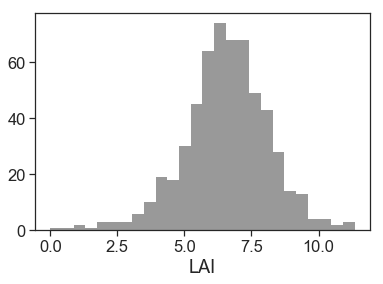

In [4]:
mean_lai = histfile.variables['ELAI'][:,startyear*12:endyear*12,0].mean(axis=1)
lai_series = pd.Series(mean_lai, name='LAI')
sns.distplot(lai_series, kde=False, rug=False, color="k")

#### Plot a joint ditribution of LAI and GPP values.

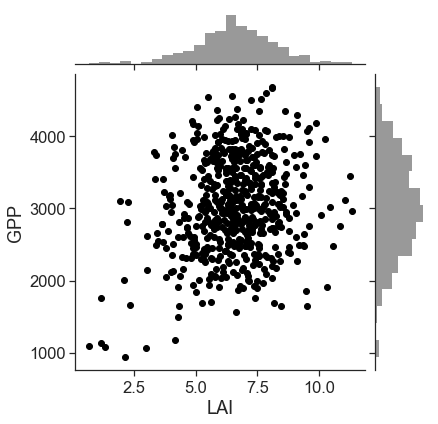

In [5]:
mean_gpp = np.ma.masked_array(histfile.variables['GPP'][:,startyear*12:endyear*12,0].mean(axis=1) * 86400 *365, mask=np.logical_not(survived))
gpp_series = pd.Series(mean_gpp, name='GPP')
sns.jointplot(x=lai_series, y=gpp_series, color="k");


#### Let's now make a plot of biomass trajectories, to see where we are at in terms of steady-state and the overall progression of biomass accumulation across the ensemble members.

Text(0,0.5,'Biomass (g C / m2)')

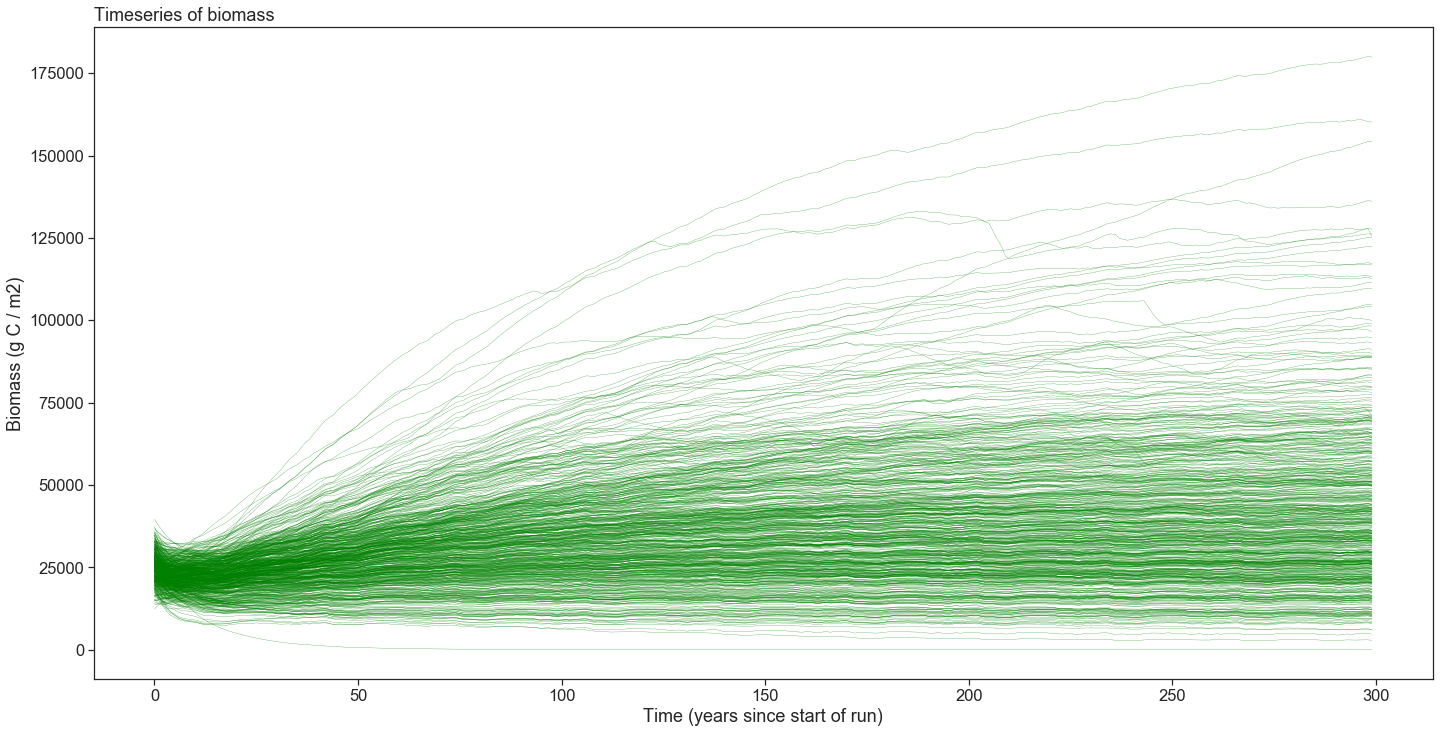

In [6]:
biomass_trajectory_annual = biomass_var[:,::12,0]
biomass_trajectory_annual.shape
time = np.arange(biomass_trajectory_annual.shape[1])
biomass_df = pd.DataFrame(biomass_trajectory_annual)
 
fig=plt.figure(figsize=(24, 12))

# multiple line plot
for column in range(nens):
    plt.plot(time, biomass_trajectory_annual[column,:], marker='', linewidth=0.25, alpha=0.9, color='green')
 
# Add titles
plt.title("Timeseries of biomass", loc='left')
plt.xlabel("Time (years since start of run)")
plt.ylabel("Biomass (g C / m2)")




# Understanding some parametric control

Now we will plot several instances of the trait covariance matrix as colored by various model predictions, in order to understand how the paramters govern various model predictions.

# Comparison of FATES against observational datasets
## Eddy-Covariance Data

#### Now let's compare the seasonal cycles of GPP, LH, and SH against flux tower observations. First load and process the eddy covariance data.

In [7]:
bci_fluxtower_datafilename = 'benchmark_datasets/BCI_v3.1.csv'

bci_fluxtower_data = np.genfromtxt(bci_fluxtower_datafilename, dtype={'names': ('date','tair','RH','vpd','p_kpa','PPT','Rs','Rs_dn','Rl_dn','Rl_up','Rnet','LE','H','Par_tot','Par_diff','SWC','ubar','ustar','WD','gpp','FLAG'),'formats': ('S16','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4')}, delimiter=',', skip_header=2)

ntim = len(bci_fluxtower_data)

time_start = datetime.datetime(2010, 1, 1, 0, 00)

tdelt = np.ma.masked_all(ntim)
month = np.ma.masked_all(ntim, dtype=np.int)
year = np.ma.masked_all(ntim, dtype=np.int)
gpp = np.ma.masked_all(ntim)
LE = np.ma.masked_all(ntim)
H = np.ma.masked_all(ntim)

for i in range(ntim):
    ts = dateutil.parser.parse(bci_fluxtower_data[i][0])
    tdelt[i] = (ts - time_start).days + (ts - time_start).seconds / 86400.
    month[i] = ts.month
    year[i] = ts.year
    gpp[i] = bci_fluxtower_data[i][19]
    LE[i] = bci_fluxtower_data[i][11]
    H[i] = bci_fluxtower_data[i][12]

H_masked = np.ma.masked_invalid(H)

nyears = (year.max() - year.min()) + 1
nmonths = nyears * 12

gpp_monthly = np.ma.masked_all(nmonths)
gpp_monthyear = np.ma.masked_all([nyears,12])
LE_monthyear = np.ma.masked_all([nyears,12])
H_monthyear = np.ma.masked_all([nyears,12])

for i in range(nyears):
    for j in range(12):
        mask = (year[:] == (year.min() + i)) * (month[:] == (j + 1))
        index = i*12 + j
        # gpp_monthly2[index] = gpp[mask].mean()                                                                                                                                                                                                                              
        if mask.sum() > 0:
            gpp_monthly[index] = (gpp * mask).sum() / mask.sum()
            gpp_monthyear[i,j] = gpp_monthly[index]
            LE_monthyear[i,j] = (LE * mask).sum() / mask.sum()
        H_monthyear[i,j] = H_masked[mask].mean()

months = np.arange(12)

### change gpp units to grams or carbon per meter squared per year
gpp_gcm2y = gpp_monthyear * 1e-6 * 12.0107 * (86400 * 365.25)


#### Now lets plot seasonal cycles of GPP from FATES and the tower data together.

Text(7,3700,'FATES ensemble members')

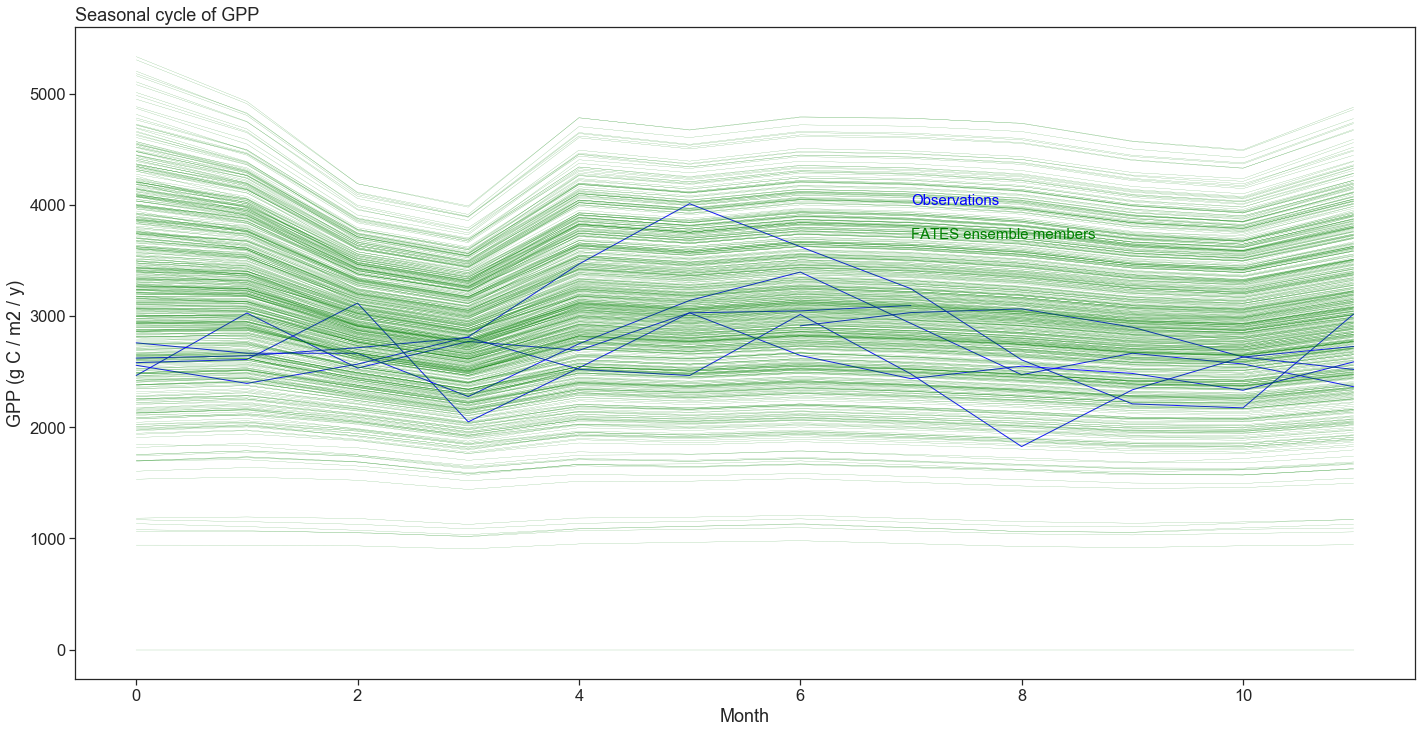

In [8]:
# calculate sesonal cycle of GPP from FATES ensembles
gpp_seascycle = np.ma.masked_all([nens, 12])
offset = 7  # first month is actually June, so I need to add this to get to January

for i in range(12):
    gpp_seascycle[:,i] = histfile.variables['GPP'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1) * 86400 *365

fig=plt.figure(figsize=(24, 12))

plt.plot(months, gpp_gcm2y.transpose(), marker='', linewidth=1.0, alpha=0.9, color='blue')

plt.plot(months, gpp_seascycle.transpose(), linewidth=0.15, alpha=0.9, color='green')

plt.title("Seasonal cycle of GPP", loc='left')
plt.xlabel("Month")
plt.ylabel("GPP (g C / m2 / y)")

plt.text(7, 4000, 'Observations', color ='blue', fontsize=15)
plt.text(7, 3700, 'FATES ensemble members', color ='green', fontsize=15)

#### Now lets plot sesaonal cycles of LH from FATES and the tower data together

Text(7,90,'FATES ensemble members')

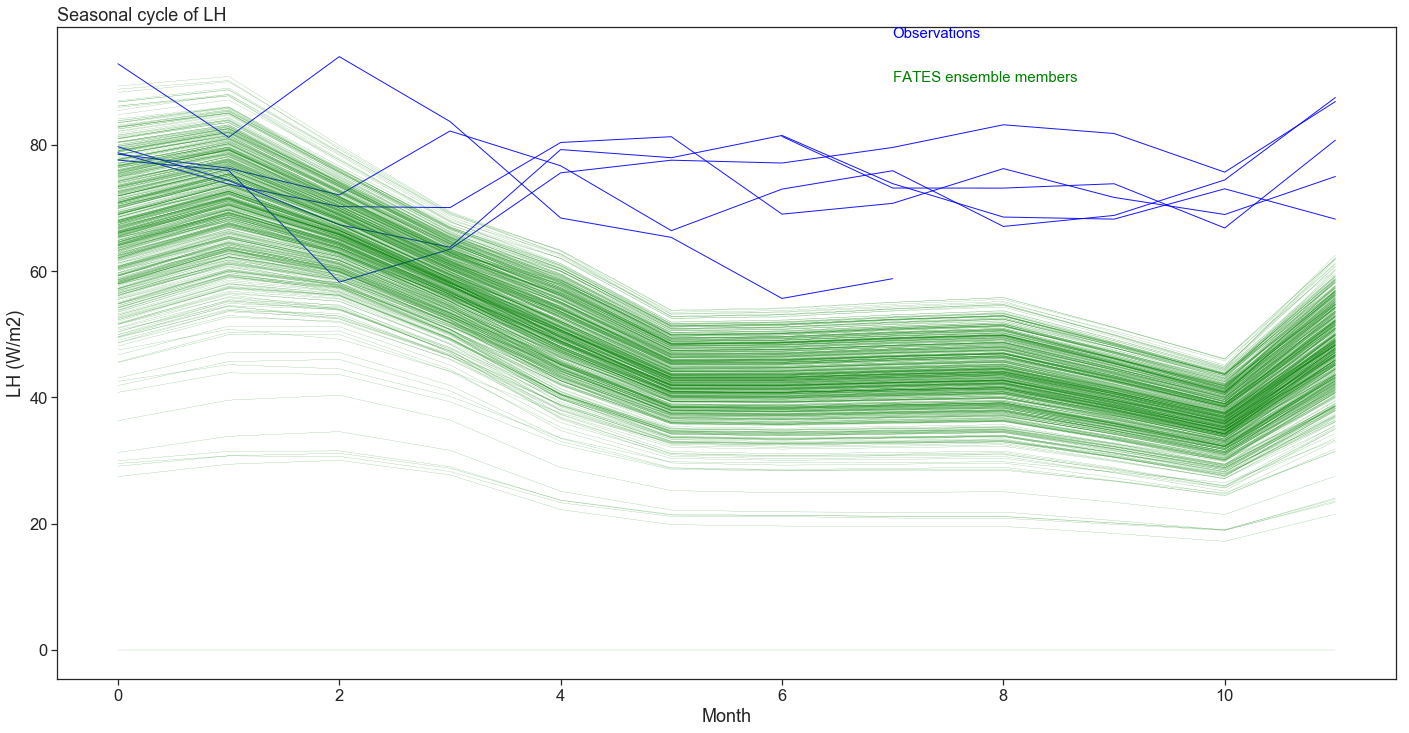

In [9]:
# calculate sesonal cycle of LH from FATES ensembles
LH_seascycle = np.ma.masked_all([nens, 12])

for i in range(12):
    LH_seascycle[:,i] = histfile.variables['FCTR'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1)
    +histfile.variables['FGEV'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1)
    +histfile.variables['FCEV'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1)
    
fig=plt.figure(figsize=(24, 12))

plt.plot(months, LE_monthyear.transpose(), marker='', linewidth=1.0, alpha=0.9, color='blue')

plt.plot(months, LH_seascycle.transpose(), linewidth=0.15, alpha=0.9, color='green')

plt.title("Seasonal cycle of LH", loc='left')
plt.xlabel("Month")
plt.ylabel("LH (W/m2)")


plt.text(7, 97, 'Observations', color ='blue', fontsize=15)
plt.text(7, 90, 'FATES ensemble members', color ='green', fontsize=15)

#### Now lets plot seasonal cycles of SH from FATES and the tower data together

Text(7,90,'FATES ensemble members')

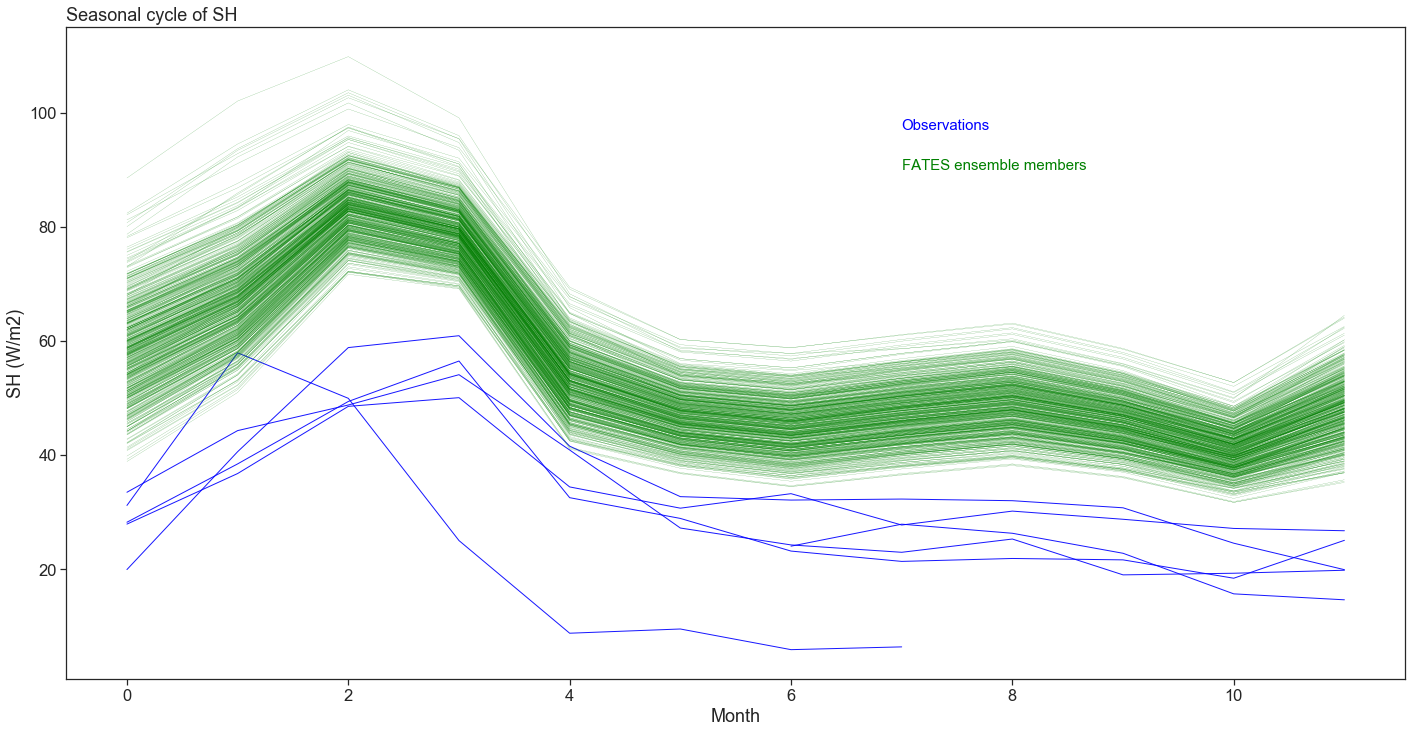

In [10]:
# calculate sesonal cycle of SH from FATES ensembles
SH_seascycle = np.ma.masked_all([nens, 12])

for i in range(12):
    SH_seascycle[:,i] = histfile.variables['FSH'][:,offset+i+(startyear)*12:offset+i+endyear*12:12,0].mean(axis=1)

fig=plt.figure(figsize=(24, 12))

plt.plot(months, H_monthyear.transpose(), marker='', linewidth=1.0, alpha=0.9, color='blue')

plt.plot(months, SH_seascycle.transpose(), linewidth=0.15, alpha=0.9, color='green')

plt.title("Seasonal cycle of SH", loc='left')
plt.xlabel("Month")
plt.ylabel("SH (W/m2)")


plt.text(7, 97, 'Observations', color ='blue', fontsize=15)
plt.text(7, 90, 'FATES ensemble members', color ='green', fontsize=15)

## Census Data

We want to load the size-structured FATES output data and compare this to BCI census data.

#### First load the raw size distribution data.  Plot as number density in log/log space

36
(36,)
(576, 36)
(25,)
(25,)


Text(30,6000,'FATES ensemble members')

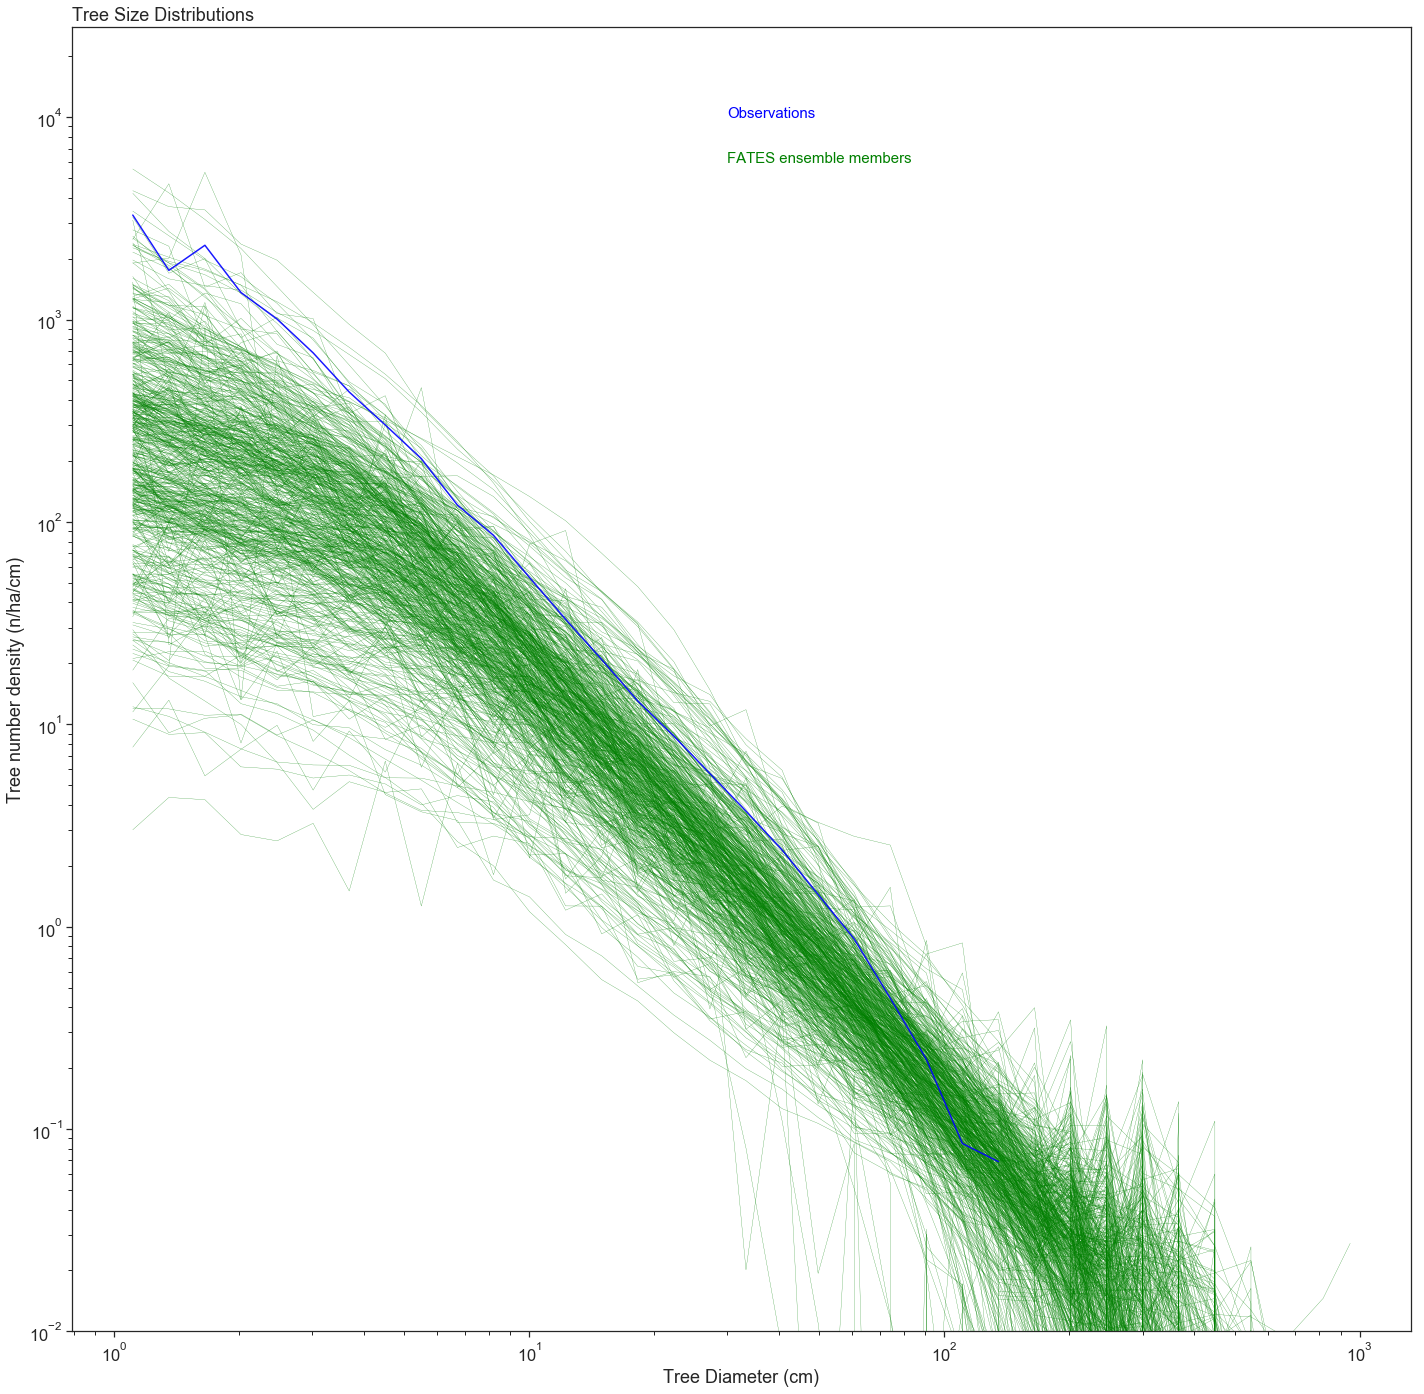

In [11]:
nplant_scpf = histfile2.variables['NPLANT_SCPF']
nplant_scls = nplant_scpf[:,:,0:36,:] + nplant_scpf[:,:,36:72,:]

fates_levscls = histfile2.variables['fates_levscls'][:]

nlevscls= len(fates_levscls)
print(nlevscls)

biggest_size = 1000.
nlevscls_orig = 26

levscls_ext = np.append(fates_levscls,biggest_size)
dlevscls = levscls_ext[1:] - levscls_ext[0:len(levscls_ext)-1]
print(dlevscls.shape)
levscls_mid = fates_levscls + dlevscls/2.
levscls_ext_logscale = levscls_ext.copy()
levscls_ext_logscale[0] = .5

nplant_scls_timeave = nplant_scls[:,startyear:endyear,:,0].mean(axis=1)

print(nplant_scls_timeave.shape)

nplant_scls_timeave_n_percm =  nplant_scls_timeave/dlevscls

## open BCI inventory data plot                                                                                                                                 
filename_bci_inventory = 'benchmark_datasets/census_bmks_lscaled_allyears_1pft_v4_25scbci_181101.nc'
fin_bci_inv = nc4.Dataset(filename_bci_inventory)

## load size distributions from census data
sizedist_inv = fin_bci_inv.variables['abund_by_size_census'][:,:,1]
sizedist_inv_timeave = sizedist_inv[:,:].mean(axis=0)
print(sizedist_inv_timeave.shape)

# get error on obs and ready that too                                                                                                                           
sizedist_inv_error_ll = np.ma.masked_all([2,len(levscls_mid)-1])
sizedist_inv_error_ul = np.ma.masked_all([2,len(levscls_mid)-1])
print((fin_bci_inv.variables['abund_by_size_census'][:,:,0].min(axis=0)/dlevscls[1:nlevscls_orig]).shape)


sizedist_inv_error_ll[1,1:nlevscls_orig] = fin_bci_inv.variables['abund_by_size_census'][:,:,0].min(axis=0)/dlevscls[1:nlevscls_orig]
sizedist_inv_error_ul[1,1:nlevscls_orig] = fin_bci_inv.variables['abund_by_size_census'][:,:,2].max(axis=0)/dlevscls[1:nlevscls_orig]

fig=plt.figure(figsize=(24, 24))

for column in range(nens):
    plt.loglog(levscls_mid[1:], nplant_scls_timeave_n_percm[column,1:], marker='', linewidth=0.25, alpha=0.9, color='green')

plt.loglog(levscls_mid[1:nlevscls_orig], sizedist_inv[:].mean(axis=0)/dlevscls[1:nlevscls_orig], marker='', linewidth=1.5, alpha=0.9, color='blue')

# Add titles
plt.title("Tree Size Distributions", loc='left')
plt.xlabel("Tree Diameter (cm)")
plt.ylabel("Tree number density (n/ha/cm)")
plt.ylim(ymin=1e-2)


plt.text(30, 1e4, 'Observations', color ='blue', fontsize=15)
plt.text(30, 0.6e4, 'FATES ensemble members', color ='green', fontsize=15)

#### Plot growth rates, conditional on size

Text(100,3.4,'FATES ensemble members')

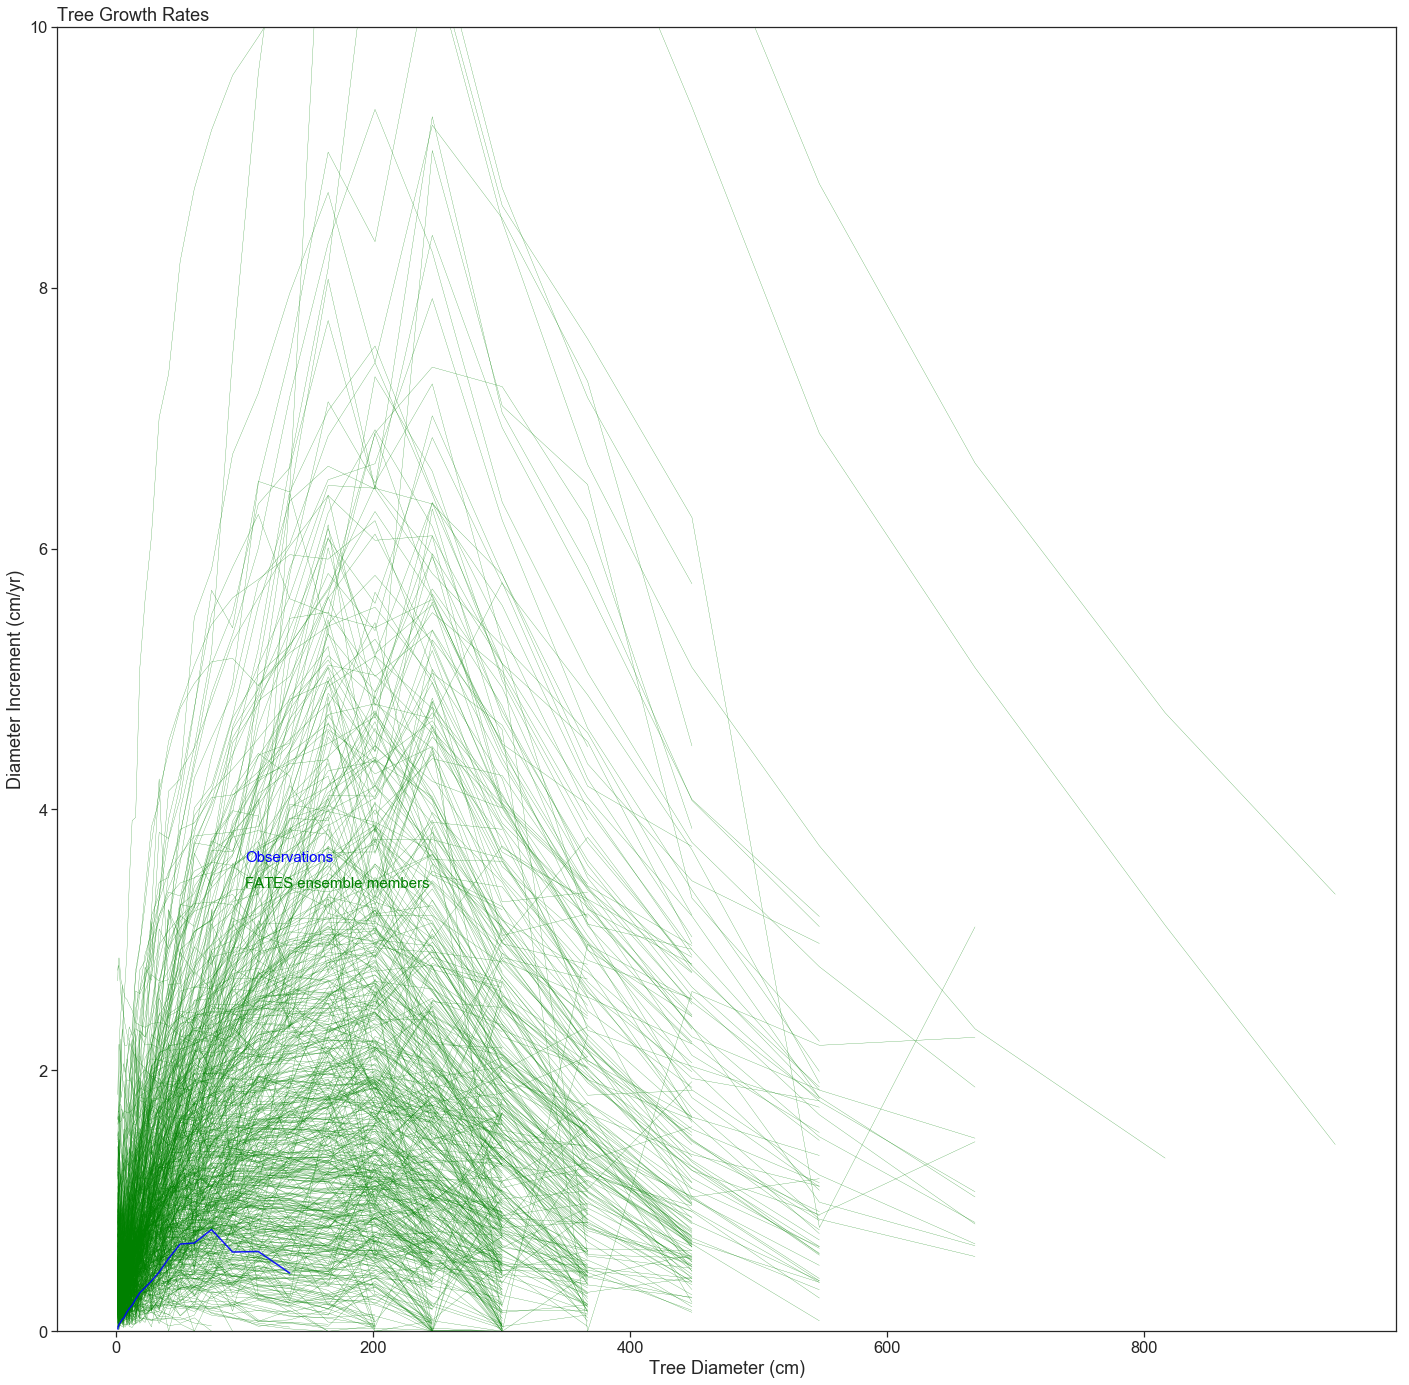

In [12]:
## read census data
growth_rate_inv = fin_bci_inv.variables['growth_increment_by_size_census'][:,:,1]
dclass_inv = fin_bci_inv.variables['dclass'][:]
ddbh_inv_error_ll = np.ma.masked_all([2,len(levscls_mid)])
ddbh_inv_error_ul = np.ma.masked_all([2,len(levscls_mid)])
ddbh_inv_error_ll[1,1:nlevscls_orig] = fin_bci_inv.variables['growth_increment_by_size_census'][1:,:,0].min(axis=0)
ddbh_inv_error_ul[1,1:nlevscls_orig] = fin_bci_inv.variables['growth_increment_by_size_census'][1:,:,2].max(axis=0)

## FATES
ddbh_scls = (histfile2.variables['DDBH_CANOPY_SCPF'][:,startyear:endyear,0:nlevscls,0].mean(axis=1) 
             + histfile2.variables['DDBH_UNDERSTORY_SCPF'][:,startyear:endyear,0:nlevscls,0].mean(axis=1)
             + histfile2.variables['DDBH_CANOPY_SCPF'][:,startyear:endyear,nlevscls:nlevscls*2,0].mean(axis=1) 
             + histfile2.variables['DDBH_UNDERSTORY_SCPF'][:,startyear:endyear,nlevscls:nlevscls*2,0].mean(axis=1)
            )/ nplant_scls_timeave

fig=plt.figure(figsize=(24, 24))

for column in range(nens):
    plt.plot(levscls_mid[1:], ddbh_scls[column,1:], marker='', linewidth=0.25, alpha=0.9, color='green')

plt.plot(levscls_mid[1:nlevscls_orig], growth_rate_inv[:,:].mean(axis=0), marker='', linewidth=1.5, alpha=0.9, color='blue')


# Add titles
plt.title("Tree Growth Rates", loc='left')
plt.xlabel("Tree Diameter (cm)")
plt.ylabel("Diameter Increment (cm/yr)")
plt.ylim(ymax=10)
plt.ylim(ymin=0)

plt.text(100, 3.6, 'Observations', color ='blue', fontsize=15)
plt.text(100, 3.4, 'FATES ensemble members', color ='green', fontsize=15)

Text(100,3.4,'FATES ensemble members')

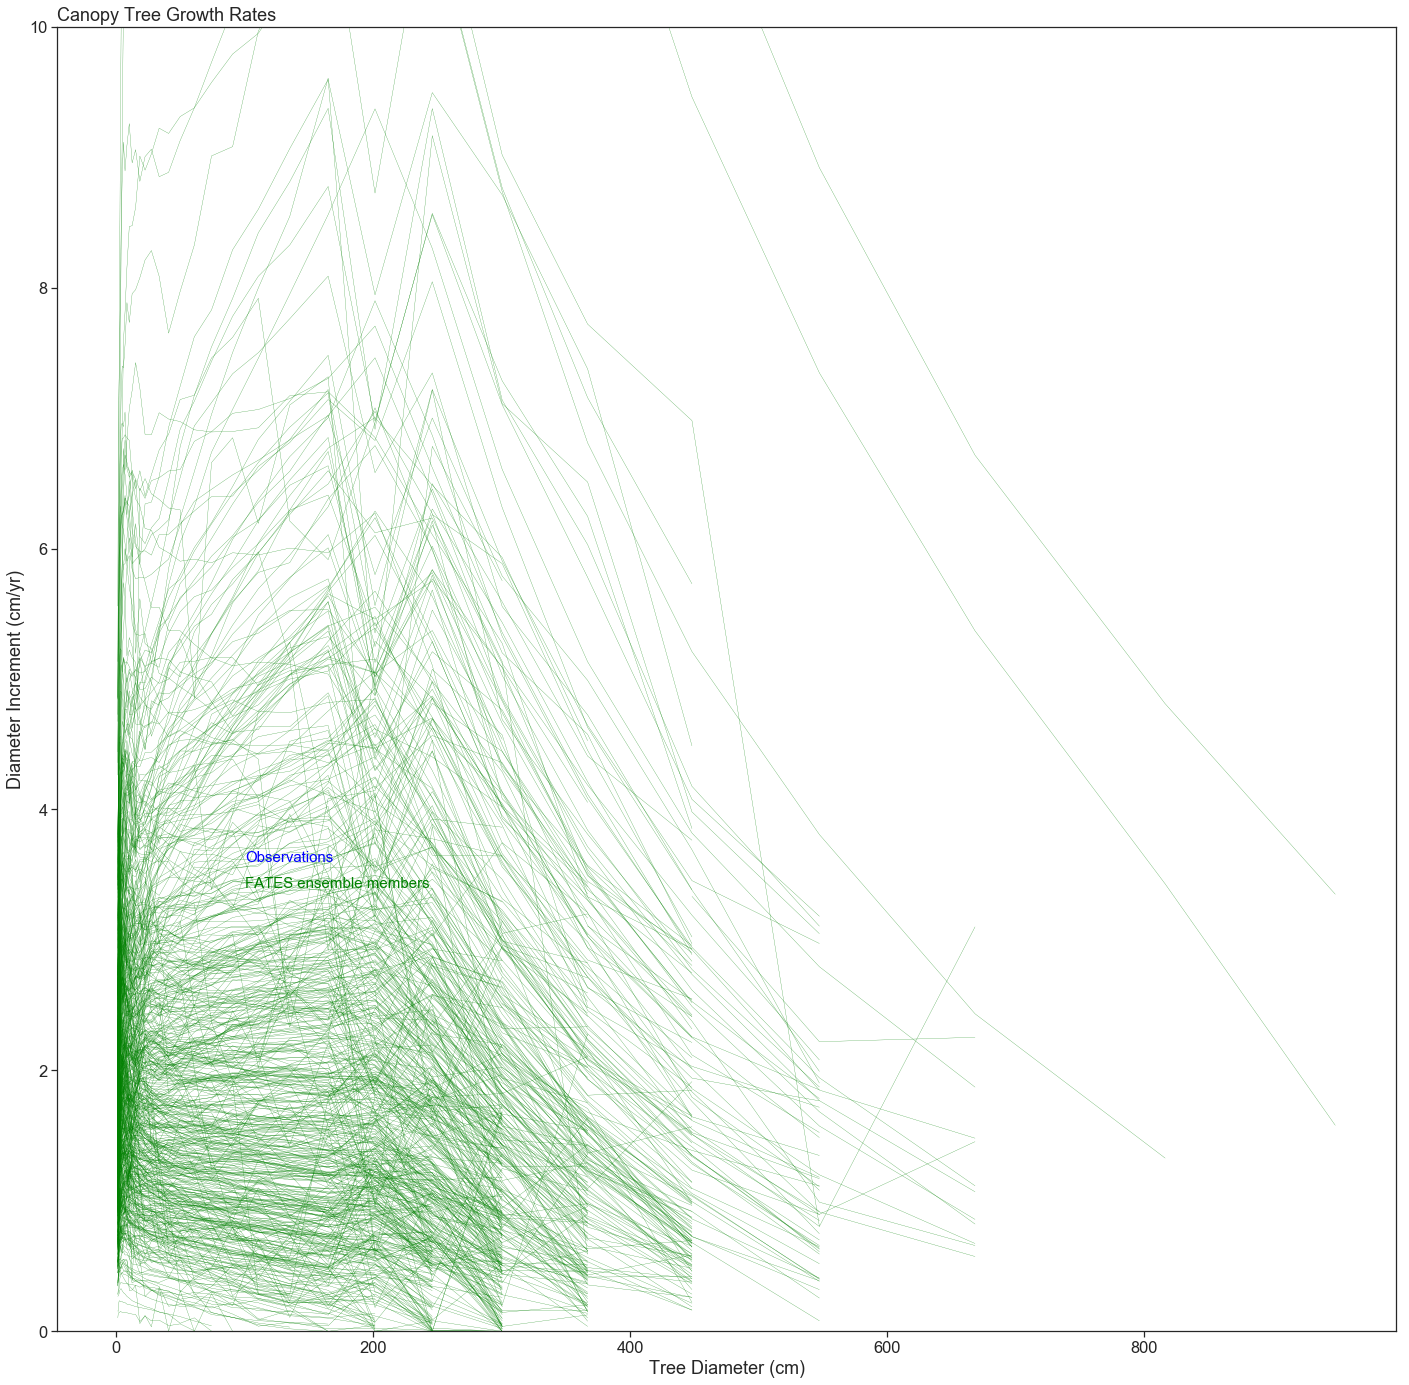

In [13]:
## FATES DDBH by canopy strata

nplant_canopy_scpf = histfile2.variables['NPLANT_CANOPY_SCPF']
nplant_canopy_scls = nplant_canopy_scpf[:,:,0:nlevscls,:] + nplant_canopy_scpf[:,:,nlevscls:nlevscls*2,:]
nplant_canopy_scls_timeave = nplant_canopy_scls[:,startyear:endyear,:,0].mean(axis=1)

ddbh_canopy_scls = (histfile2.variables['DDBH_CANOPY_SCPF'][:,startyear:endyear,0:nlevscls,0].mean(axis=1) 
             + histfile2.variables['DDBH_CANOPY_SCPF'][:,startyear:endyear,nlevscls:nlevscls*2,0].mean(axis=1) 
            )/ nplant_canopy_scls_timeave

fig=plt.figure(figsize=(24, 24))

for column in range(nens):
    plt.plot(levscls_mid[1:], ddbh_canopy_scls[column,1:], marker='', linewidth=0.25, alpha=0.9, color='green')

# Add titles
plt.title("Canopy Tree Growth Rates", loc='left')
plt.xlabel("Tree Diameter (cm)")
plt.ylabel("Diameter Increment (cm/yr)")
plt.ylim(ymax=10)
plt.ylim(ymin=0)

plt.text(100, 3.6, 'Observations', color ='blue', fontsize=15)
plt.text(100, 3.4, 'FATES ensemble members', color ='green', fontsize=15)

#### Mortality Rates, as conditional on size distributions.

Text(100,0.32,'FATES ensemble members')

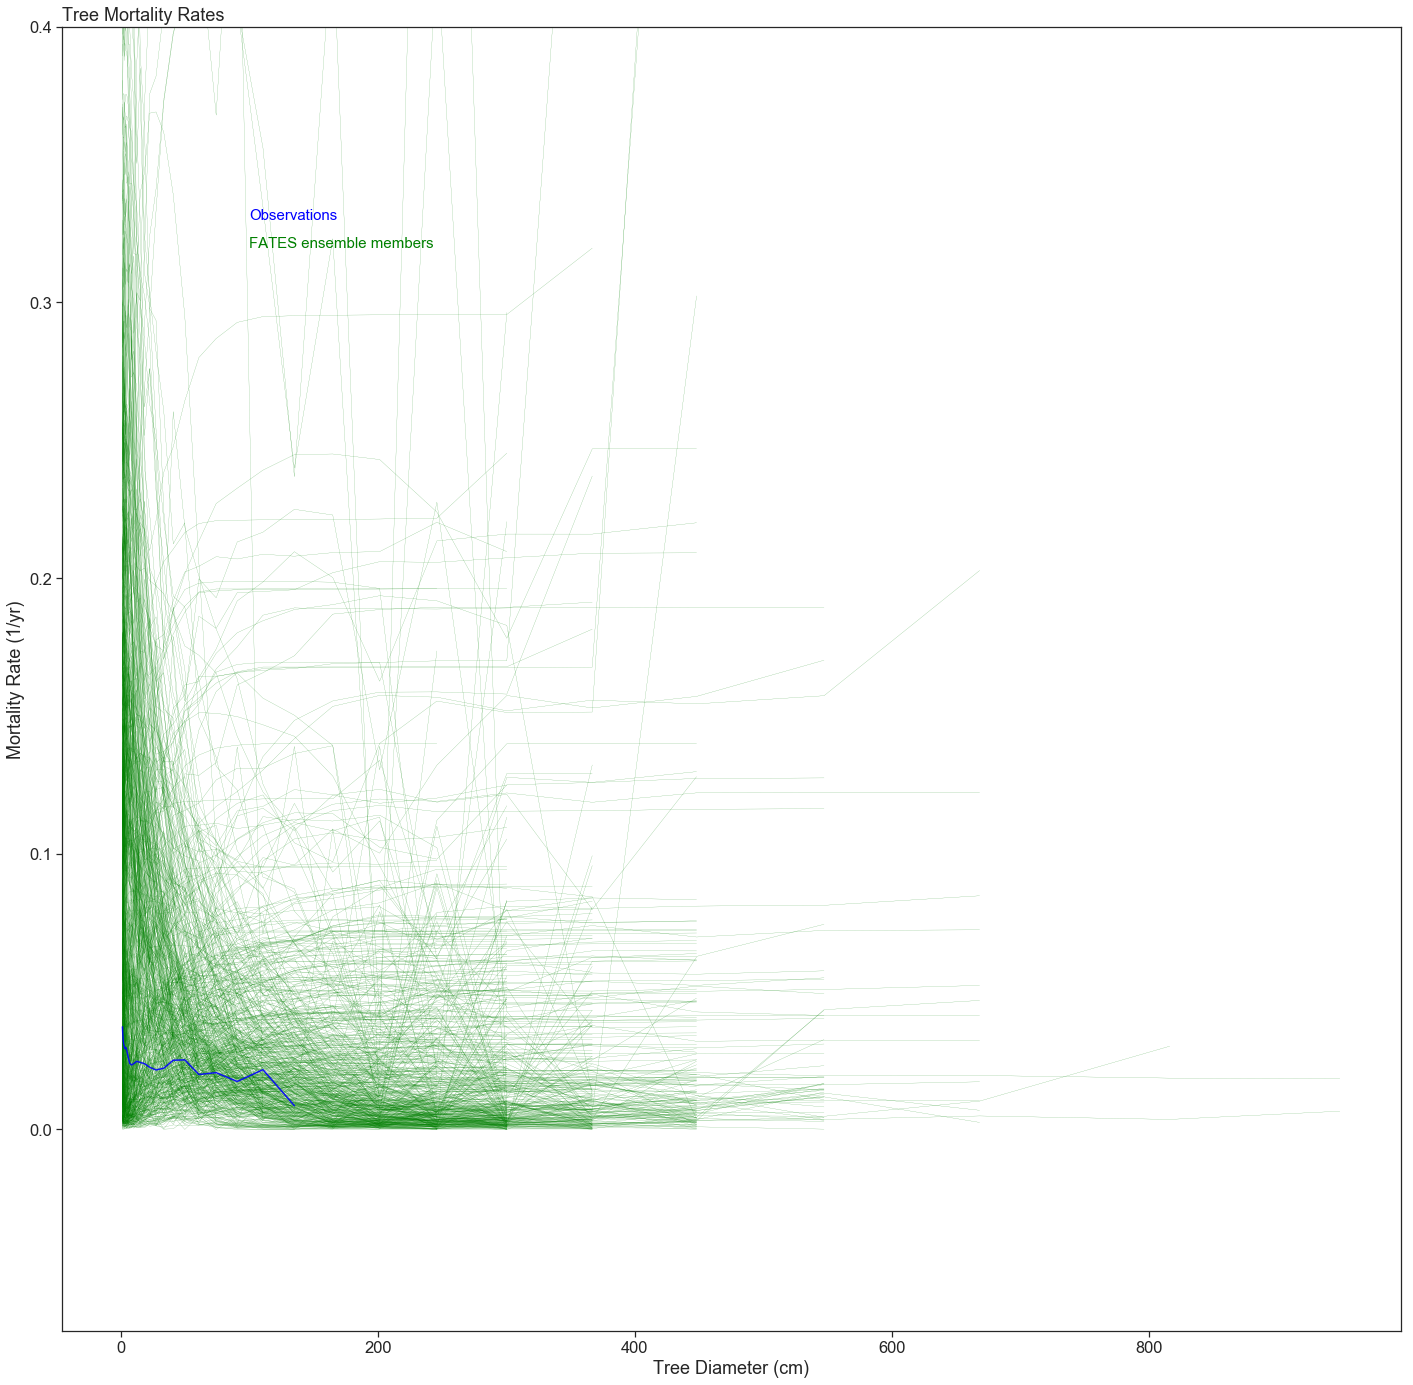

In [14]:
## load census data
mort_rate_inv = fin_bci_inv.variables['mortality_rate_by_size_census'][:,:,1]
mort_rate_inv_mean = mort_rate_inv[1:,:].mean(axis=0)
    
mort_inv_error_ll = np.ma.masked_all([2,len(levscls_mid)])
mort_inv_error_ul = np.ma.masked_all([2,len(levscls_mid)])
mort_inv_error_ll[1,1:nlevscls_orig] = fin_bci_inv.variables['mortality_rate_by_size_census'][1:,:,0].min(axis=0)
mort_inv_error_ul[1,1:nlevscls_orig] = fin_bci_inv.variables['mortality_rate_by_size_census'][1:,:,2].max(axis=0)

## FATES
mortality_scls = (histfile2.variables['MORTALITY_CANOPY_SCPF'][:,startyear:endyear,0:nlevscls,0].mean(axis=1) + 
                 histfile2.variables['MORTALITY_CANOPY_SCPF'][:,startyear:endyear,0:nlevscls,0].mean(axis=1) + 
                 histfile2.variables['MORTALITY_UNDERSTORY_SCPF'][:,startyear:endyear,nlevscls:nlevscls*2,0].mean(axis=1)+
                 histfile2.variables['MORTALITY_UNDERSTORY_SCPF'][:,startyear:endyear,nlevscls:nlevscls*2,0].mean(axis=1)
                 ) / nplant_scls_timeave

fig=plt.figure(figsize=(24, 24))

for column in range(nens):
    plt.plot(levscls_mid[1:], mortality_scls[column,1:], marker='', linewidth=0.15, alpha=0.9, color='green')

plt.plot(levscls_mid[1:nlevscls_orig], mort_rate_inv_mean, marker='', linewidth=1.5, alpha=0.9, color='blue')


# Add titles
plt.title("Tree Mortality Rates", loc='left')
plt.xlabel("Tree Diameter (cm)")
plt.ylabel("Mortality Rate (1/yr)")
plt.ylim(ymax=0.4)


plt.text(100, 0.33, 'Observations', color ='blue', fontsize=15)
plt.text(100, 0.32, 'FATES ensemble members', color ='green', fontsize=15)

## Vertical profiles profiles of canopy and leaf height (to compare to LIDAR data)
#### First plot the vertical profile of leaf area, which does not take into account any information about the relative position of leaves with respect to each other, just where all the leaves are through the canopy.

Text(0.8,45,'FATES ensemble members')

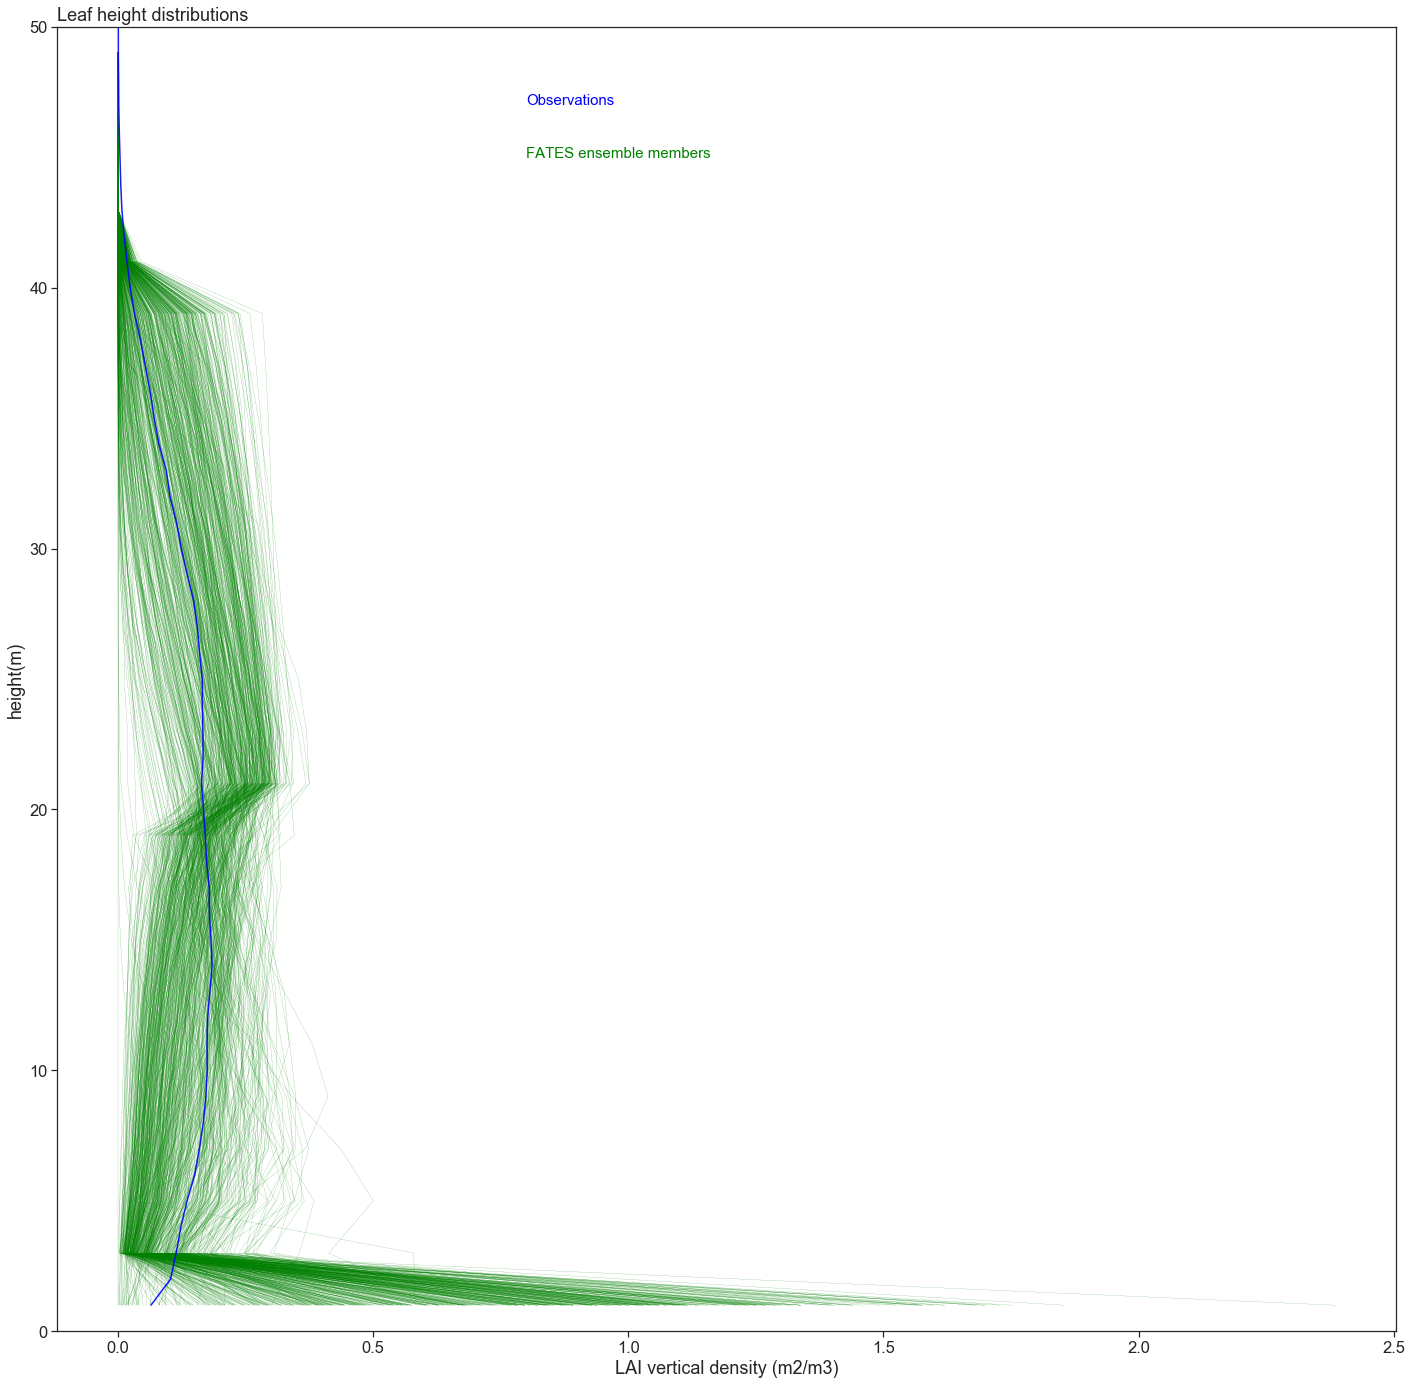

In [15]:
heightlevs = histfile2.variables['fates_levheight'][:]
dz = heightlevs[1]-heightlevs[0]
heightlevs_midpoint = dz/2. + heightlevs

### load LIDAR estimate of LAD from Detto et al 2015
filename_lidar_leafareadens = 'benchmark_datasets/LAD.csv'
lidar_leafareadens_file = pd.read_csv(filename_lidar_leafareadens)
#print(lidar_leafareadens_file.dtypes)
#print(lidar_leafareadens_file['Height (m)'].values)
#print(lidar_leafareadens_file['LAD'].values)


leafheight = histfile2.variables['LEAF_HEIGHT_DIST'][:,startyear:endyear,:,0].mean(axis=1) / dz

fig=plt.figure(figsize=(24, 24))

for column in range(nens):
    plt.plot(leafheight[column,:], heightlevs_midpoint[:], marker='', linewidth=0.15, alpha=0.9, color='green')

plt.plot(lidar_leafareadens_file['LAD'], 1.*lidar_leafareadens_file['Height (m)'], marker='', linewidth=1.5, alpha=0.9, color='blue')

plt.title("Leaf height distributions", loc='left')
plt.xlabel("LAI vertical density (m2/m3)")
plt.ylabel("height(m)")
plt.ylim(0.,50.)
plt.text(0.8, 47, 'Observations', color ='blue', fontsize=15)
plt.text(0.8, 45, 'FATES ensemble members', color ='green', fontsize=15)

#### Next plot the vertical profile of top canopy height, which is the top of each cohort that is in the canopy strata, so is the other extreme endmember of a height distributio that takes relative position completely into account.

Text(0.3,45,'FATES ensemble members')

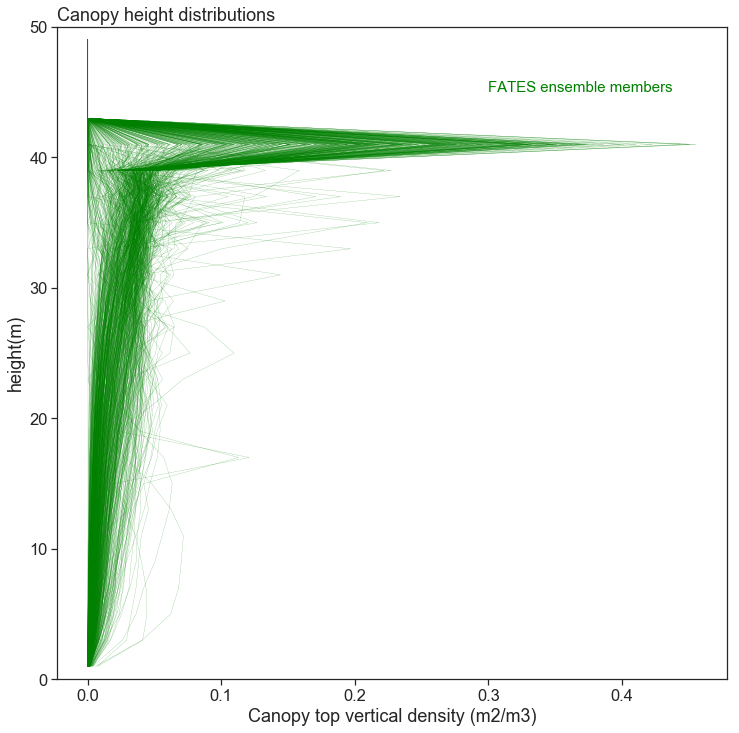

In [16]:
canopyheight = histfile2.variables['CANOPY_HEIGHT_DIST'][:,startyear:endyear,:,0].mean(axis=1)/ dz

fig=plt.figure(figsize=(12, 12))

for column in range(nens):
    plt.plot(canopyheight[column,:], heightlevs_midpoint[:], marker='', linewidth=0.15, alpha=0.9, color='green')


plt.title("Canopy height distributions", loc='left')
plt.xlabel("Canopy top vertical density (m2/m3)")
plt.ylabel("height(m)")
plt.ylim(0.,50.)
#plt.text(0.3, 47, 'Observations', color ='blue', fontsize=15)
plt.text(0.3, 45, 'FATES ensemble members', color ='green', fontsize=15)

## Diagnose the level of coexistence, and plot it conditional on growth and mortality rates of canopy and understory trees

In [17]:
refsize_lower = 15.
lev_refsize_lower = np.argmin(np.abs(levscls_mid - refsize_lower))

refsize_upper = 30.
lev_refsize_upper = np.argmin(np.abs(levscls_mid - refsize_upper))


## reshape the log_trait array so that it has dimension (pft x ensemble x trait)
#print(traits_matrix_partiallylog.shape)
ntraits = traits_matrix_partiallylog.shape[1]
traits_matrix_partiallylog_reshaped = np.reshape(traits_matrix_partiallylog, [nens,npfts,ntraits])

## ensure the traits matrix lines up with the netcdf version 
#print(traits_matrix_partiallylog_reshaped.shape)
#log_vcmaxvar = np.squeeze(np.log10(paramfile.variables['fates_leaf_vcmax25top'][:]))
#print(log_vcmaxvar.shape)
#print(log_vcmaxvar[2,:])
#print(traits_matrix_partiallylog_reshaped[2,:,0])

nrates = 4

In [18]:
print(nlevscls)

print(lev_refsize_lower)
print(lev_refsize_upper)
## calculate the growth and mortality rates of the canopy and understory trees
print(histfile2.variables['DDBH_CANOPY_SCPF'].shape)

startyear2 = 2
endyear2 = 50

year_bimoass_start = 290
year_biomass_end = 300

growth_rate_canopy_pft1 = histfile2.variables['DDBH_CANOPY_SCPF'][:,startyear2:endyear2,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)/histfile2.variables['NPLANT_CANOPY_SCPF'][:,startyear:endyear,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)
growth_rate_canopy_pft2 = histfile2.variables['DDBH_CANOPY_SCPF'][:,startyear2:endyear2,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)/histfile2.variables['NPLANT_CANOPY_SCPF'][:,startyear:endyear,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)

mort_rate_canopy_pft1 = histfile2.variables['MORTALITY_CANOPY_SCPF'][:,startyear2:endyear2,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)/histfile2.variables['NPLANT_CANOPY_SCPF'][:,startyear:endyear,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)
mort_rate_canopy_pft2 = histfile2.variables['MORTALITY_CANOPY_SCPF'][:,startyear2:endyear2,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)/histfile2.variables['NPLANT_CANOPY_SCPF'][:,startyear:endyear,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)

growth_rate_understory_pft1 = histfile2.variables['DDBH_UNDERSTORY_SCPF'][:,startyear2:endyear2,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).mean(axis=1)/histfile2.variables['NPLANT_UNDERSTORY_SCPF'][:,startyear:endyear,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)
growth_rate_understory_pft2 = histfile2.variables['DDBH_UNDERSTORY_SCPF'][:,startyear2:endyear2,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)/histfile2.variables['NPLANT_UNDERSTORY_SCPF'][:,startyear:endyear,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)

mort_rate_understory_pft1 = histfile2.variables['MORTALITY_UNDERSTORY_SCPF'][:,startyear2:endyear2,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).mean(axis=1)/histfile2.variables['NPLANT_UNDERSTORY_SCPF'][:,startyear:endyear,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)
mort_rate_understory_pft2 = histfile2.variables['MORTALITY_UNDERSTORY_SCPF'][:,startyear2:endyear2,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)/histfile2.variables['NPLANT_UNDERSTORY_SCPF'][:,startyear:endyear,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)

dominant_pft_frac = np.squeeze(histfile2.variables['PFTbiomass'][:,year_bimoass_start:year_biomass_end,:].mean(axis=1).max(axis=1) / histfile2.variables['PFTbiomass'][:,year_bimoass_start:year_biomass_end,:].mean(axis=1).sum(axis=1))
pft1_frac = np.squeeze(histfile2.variables['PFTbiomass'][:,year_bimoass_start:year_biomass_end,0].mean(axis=1) / histfile2.variables['PFTbiomass'][:,year_bimoass_start:year_biomass_end,:].mean(axis=1).sum(axis=1))
print(pft1_frac.shape)
faster_growing_pft_frac = np.zeros(nens)
hist_sep = np.zeros(nens, dtype=np.int)
print(faster_growing_pft_frac.shape)
for i in range(nens):
    if (growth_rate_canopy_pft1[i] > growth_rate_canopy_pft2[i]):
        faster_growing_pft_frac[i] = pft1_frac[i]
    else:
        faster_growing_pft_frac[i] = 1.- pft1_frac[i]
        hist_sep[i] = 1

rates_array = np.zeros([nens,npfts,nrates])
rates_names = ['canopy growth (cm/y)','understory growth (cm/y)','canopy mortality (1/y)','understory mortality (1/y)']

rates_array[:,0,0] = growth_rate_canopy_pft1
rates_array[:,1,0] = growth_rate_canopy_pft2

rates_array[:,0,1] = growth_rate_understory_pft1
rates_array[:,1,1] = growth_rate_understory_pft2

rates_array[:,0,2] = mort_rate_canopy_pft1
rates_array[:,1,2] = mort_rate_canopy_pft2

rates_array[:,0,3] = mort_rate_understory_pft1
rates_array[:,1,3] = mort_rate_understory_pft2

minval = 1e-6
#rates_array = np.maximum(rates_array,minval)

log_plots = [False, False, True, True]
ranges = [[0.,20.], [0.,1.],[1e-2,1],[1.e-2,1e1]]

36
14
17
(576, 301, 72, 1)
(576,)
(576,)


/Users/cdkoven/miniconda2/envs/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Warning: converting a masked element to nan.


In [19]:
reload(map_funcs)
map_funcs.pairplot(rates_array, colors=faster_growing_pft_frac, levels=np.arange(21)/20., file='pairplot_2pft_ratespace_colormap1', log_plots=log_plots, ranges=ranges, colormap='WhBlReWh', plot_hists=False, hist_sep=hist_sep, datatitles=rates_names, labelbar=True)
map_funcs.pairplot(rates_array, colors=faster_growing_pft_frac, levels=np.arange(21)/20., file='pairplot_2pft_ratespace_colormap2', log_plots=log_plots, ranges=ranges, colormap='BlWhRe', plot_hists=False, hist_sep=hist_sep, datatitles=rates_names, labelbar=True)

1.6.1
(576, 2, 4)
(576, 2, 4)


In [20]:
print(type(dominant_pft_frac))

<class 'numpy.ma.core.MaskedArray'>
